In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import os
from unidecode import unidecode

project_root = os.path.abspath("../..")
data_root = os.path.join(project_root, "data")

# Carregamento dos dados da Delegacia de Estrangeiros
* Carregamento dos dados consolidados via webscraping
* Limpeza/normalização das colunas de nome e exclusão de registros inválidos
* Lógica de deduplicação por número do registro de estrangeiro e coincidência de nome completo + dos pais

In [ ]:
# Carregamento dos dados, normalização dos nomes das colunas, exclusão de anos de entrada inválidos
print(os.path.join(data_root, "raw", "rne_consolidado.csv"))

rne = pd.read_csv(os.path.join(data_root, "raw", "rne_consolidado.csv"))

rne.rename(
    columns={
        "primeiro_nome_original": "prenome",
        "sobrenome_original": "sobrenome",
        "nome_completo_original": "nome_completo",
        "nome_completo_pai_original": "nome_pai",
        "nome_completo_mae_original": "nome_mae",
        "ano_entrada_alterado": "ano_entrada",
        "nacionalidade_query": "nacionalidade",
    },
    inplace=True,
)

rne.drop(
    columns=["id_estrangeiro_pk", "idioma", "nacionalidade_original"], inplace=True
)

rne["ano_entrada"] = np.where(rne["ano_entrada"] > 1830, rne["ano_entrada"], np.nan)

print(f"Dimensões do dataset após carregamento: {rne.shape}")

# Atribuindo rótulo por nacionalidade e eliminando registros sem rótulo

label_map = {
    "portuguesa": "iberica",
    "espanhola": "iberica",
    "japonesa": "japonesa",
    "italiana": "italiana",
    "alemã": "germanica",
    "libanesa": "arabe",
    "ucraniana": "leste",
    "polonesa": "leste",
    "siria": "arabe",
    "russa": "leste",
    # 'francesa': 'francesa'
}

rne["label"] = rne["nacionalidade"].map(label_map)

rne = rne.dropna(subset=["label"]).reset_index(drop=True)

display(rne["label"].value_counts())

rne.info()

# Primeira limpeza (colunas de nomes): exclusão de linhas com dados ausentes, algarismos e somente um nome

rne.dropna(subset=["nome_completo", "nome_pai", "nome_mae"], inplace=True)


def normalize_strings(series: pd.Series):
    return (
        series.astype(str)
        .str.split("~")
        .str[0]
        .str.lower()
        .apply(unidecode)
        .str.strip()
    )


normalize_cols = ["nome_completo", "nome_pai", "nome_mae", "prenome", "sobrenome"]

for col in normalize_cols:
    rne[col] = normalize_strings(rne[col])

rne = rne[
    ~(
        (rne["nome_completo"].str.contains("desconhecid|informaca"))
        | (rne["nome_pai"].str.contains("desconhecid|informaca"))
        | (rne["nome_mae"].str.contains("desconhecid|informaca"))
    )
]

rne = rne[
    ~(
        rne["nome_completo"].str.contains(r"\d")
        | rne["nome_pai"].str.contains(r"\d")
        | rne["nome_mae"].str.contains(r"\d")
    )
]

rne = rne[
    (rne["nome_completo"].str.split().str.len() > 1)
    & (rne["nome_pai"].str.split().str.len() > 1)
    & (rne["nome_mae"].str.split().str.len() > 1)
].copy()


print(f"Dimensões do dataset após limpeza das colunas de nome: {rne.shape}")

# Ordenação por ano de entrada mais antigo e colunas de nome mais extensas (tendencialmente preservando versão não abreviada dos nomes)

rne.sort_values(by="ano_entrada", ascending=True, inplace=True)

rne.sort_values(
    by=["nome_pai", "nome_mae"],
    key=lambda col: col.str.len(),
    ascending=False,
    inplace=True,
)

# Eliminar duplicatas, primeiro por coincidência do número de registro e nome, depois por coincidência do nome completo + nome de ambos os pais; considerando a ordenação anterior, deve permanecer o registro com entrada mais antiga e nome dos pais menos abreviados, para o mesmo indivíduo

rne.drop_duplicates(
    subset=["nome_completo", "nome_pai", "nome_mae"], inplace=True, keep="first"
)

mask_has_registro = rne["numero_registro"].notna()
rne_with_registro = rne[mask_has_registro].drop_duplicates(
    subset=["nome_completo", "numero_registro"], keep="first"
)
rne_without_registro = rne[~mask_has_registro]
rne = pd.concat([rne_with_registro, rne_without_registro], ignore_index=True)

print(f"Dimensões do dataset após deduplicação: {rne.shape}")

# Removendo colunas que não serão mais relevantes após este ponto
rne.drop(
    columns=["prenome", "sobrenome", "numero_certificado", "numero_registro"],
    inplace=True,
)

rne.info()

/home/arthur/Documents/data/ngram_surname_classifiers/data/raw/rne_consolidado.csv
Dimensões do dataset após carregamento: (1058880, 11)


label
iberica      466535
italiana     233830
japonesa     206411
germanica     71570
arabe         33309
leste         19487
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031142 entries, 0 to 1031141
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   prenome             1030829 non-null  object 
 1   sobrenome           1029089 non-null  object 
 2   nome_completo       1030261 non-null  object 
 3   estado_civil        950786 non-null   object 
 4   numero_certificado  434707 non-null   float64
 5   numero_registro     438662 non-null   float64
 6   nome_pai            906544 non-null   object 
 7   nome_mae            918753 non-null   object 
 8   ano_entrada         947742 non-null   float64
 9   nacionalidade       1031142 non-null  object 
 10  pagina              1031142 non-null  int64  
 11  label               1031142 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 94.4+ MB
Dimensões do dataset após limpeza das colunas de nome: (869304, 12)
Dimensões do dataset após deduplicação: (7

In [22]:
os.makedirs(os.path.join(data_root, "intermediate"), exist_ok=True)

rne.to_csv(
    os.path.join(data_root, "intermediate", "rne_preprocessado.csv"), index=False
)

# Breve exploração do dataset preprocessado, por nacionalidade e ano de entrada

In [24]:
rne = pd.read_csv(os.path.join(data_root, "intermediate", "rne_preprocessado.csv"))

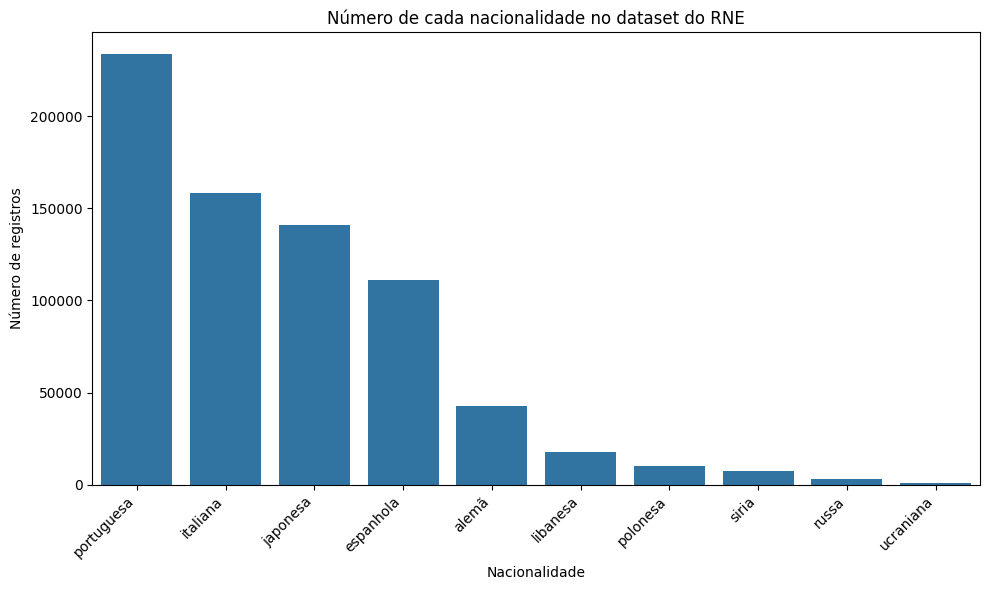

In [25]:
nat_counts = rne["nacionalidade"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=nat_counts.index, y=nat_counts.values)
plt.title("Número de cada nacionalidade no dataset do RNE")
plt.xlabel("Nacionalidade")
plt.ylabel("Número de registros")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

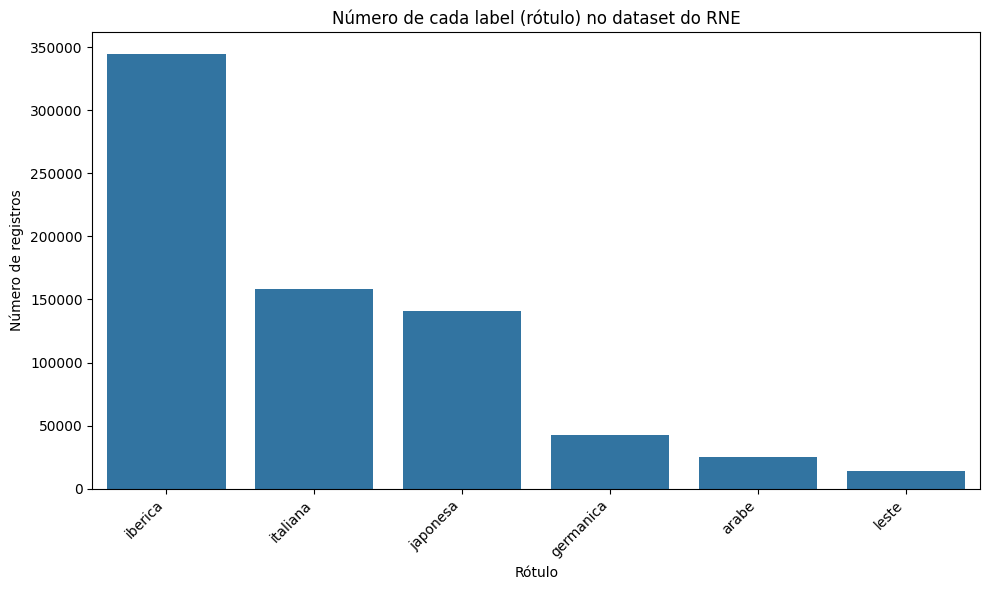

In [26]:
# prompt: plot the counts of each label in rne as a bar graph

import matplotlib.pyplot as plt

label_counts = rne["label"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Número de cada label (rótulo) no dataset do RNE")
plt.xlabel("Rótulo")
plt.ylabel("Número de registros")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

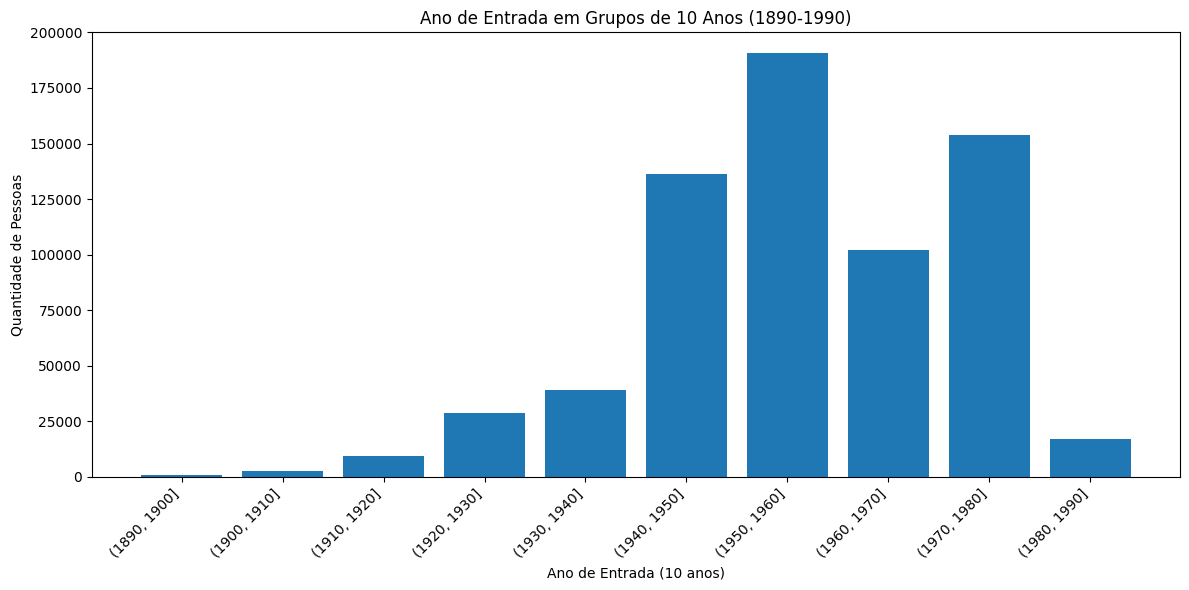

In [27]:
# prompt: plot the ano entrada in 10 year buckets from 1890 to 1990

import pandas as pd
import matplotlib.pyplot as plt

# Filter data for the desired time range
rne_filtered = rne[(rne["ano_entrada"] >= 1880) & (rne["ano_entrada"] <= 1990)]

# Group data into 10-year buckets
rne_grouped = rne_filtered.groupby(
    pd.cut(rne_filtered["ano_entrada"], range(1890, 2000, 10)), observed=False
).size()

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(rne_grouped.index.astype(str), rne_grouped.values)
plt.xlabel("Ano de Entrada (10 anos)")
plt.ylabel("Quantidade de Pessoas")
plt.title("Ano de Entrada em Grupos de 10 Anos (1890-1990)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Extração de sobrenomes por heurística
* Partimos da suposição de que o sobrenome compartilhado entre duas pessoas (pai/mãe e filho ou cônjuges entre si) no dataset seja a palavra que ocorre igualmente em ambos e esteja mais próxima do fim do nome completo de ambos, a partir do segundo elemento. Para encontrar o elemento mais final chamamos a posição final da palavra comum de "endness" e calculamos somando o índice da palavra comum em ambos os nomes, considerando um nome completo como um vetor de caracteres separados por espaços.

In [28]:
rne = pd.read_csv(os.path.join(data_root, "intermediate", "rne_preprocessado.csv"))

In [29]:
rne_post = rne.copy()


def extract_common_surname(row, col1, col2):
    """
    Extracts the common element from two columns in a row of a DataFrame,
    prioritizing elements closer to the end of the string (higher endness).

    Args:
        row: A row of a Pandas DataFrame.
        col1: The name of the first column.
        col2: The name of the second column.

    Returns:
        The common element with the highest endness, otherwise NaN.
    """

    words1 = row[col1].split()[1:]
    words2 = row[col2].split()[1:]

    # Find common elements
    common_elements = list(set(words1) & set(words2))

    if not common_elements:
        return np.nan  # No common elements

    # Calculate endness for each common element
    endness_scores = {}
    for element in common_elements:
        endness_scores[element] = words1.index(element) + words2.index(element)

    # Return the common element with the highest endness
    return max(endness_scores, key=endness_scores.get)


# Tentando extrair cada um entre sobrenome dos pais, do pai e da mãe

rne_post["parent_surname"] = rne_post.apply(
    extract_common_surname, args=("nome_pai", "nome_mae"), axis=1
)

rne_post["father_surname"] = rne_post.apply(
    extract_common_surname, args=("nome_completo", "nome_pai"), axis=1
)

rne_post["mother_surname"] = rne_post.apply(
    extract_common_surname, args=("nome_completo", "nome_mae"), axis=1
)

# Definindo partículas conectivas ou muito comuns na formação de nomes em cada língua, para que sejam desconsideradas como nomes em comum, se o foram no passo anterior

nationalities_particles = {
    "portuguesa": ["de", "da", "do", "das", "dos", "del", "la", "e", "y"],
    "espanhola": ["de", "da", "do", "das", "dos", "del", "la", "e", "y"],
    "italiana": ["di", "de"],
    "siria": ["el"],
    "libanesa": ["el"],
    # 'francesa': ['marie', 'de', 'le', 'a']
}

for nationality, particles in nationalities_particles.items():
    for column in ["parent_surname", "father_surname", "mother_surname"]:
        rne_post.loc[
            (rne_post["nacionalidade"] == nationality)
            & (rne_post[column].isin(particles)),
            column,
        ] = np.nan

# Se o sobrenome dos pais tem apenas uma letra de comprimento e essa é a inicial da letra da última palavra do nome_completo, esse deve ser o novo sobrenome dos pais
rne_post["parent_surname"] = np.where(
    (rne_post["parent_surname"].str.len() == 1)
    & (
        rne_post["parent_surname"]
        == rne_post["nome_completo"].str.split().str[-1].str[0]
    ),
    rne_post["nome_completo"].str.split().str[-1],
    np.where(
        rne_post["parent_surname"].str.len() == 1, np.nan, rne_post["parent_surname"]
    ),
)

print(f"Number of individuals: {rne_post.shape[0]}")

print(
    f"Number of individuals with a parent_surname: {rne_post['parent_surname'].notna().sum()}"
)

print(
    f"Number of individuals with a father_surname: {rne_post['father_surname'].notna().sum()}"
)

print(
    f"Number of individuals with a mother_surname: {rne_post['mother_surname'].notna().sum()}"
)

# # add a self_surname column with the last word in nome_completo only where estado_civil == S
# rne_post['self_surname'] = np.where(
#     rne_post['estado_civil'] == 'S',
#     rne_post['nome_completo'].str.split().str[-1],
#     np.nan
# )

# print(f"Number of individuals with a self_surname: {rne_post['self_surname'].notna().sum()}")

Number of individuals: 726124
Number of individuals with a parent_surname: 297831
Number of individuals with a father_surname: 594753
Number of individuals with a mother_surname: 377535


## Brevemente explorando a taxa de sucesso da extração de sobrenomes para todo o dataset e por nacionalidade

In [30]:
# prompt: display the percentage of each nationality that has parent_surname, father_surname and mother_surname (per the nationality categories, each in a dataframe)

# Assuming rne_post DataFrame is already loaded and processed


def calculate_surname_percentages(df):
    """Calculates the percentage of each nationality with parent_surname, father_surname, and mother_surname."""

    nationality_counts = df.groupby("nacionalidade").size().rename("total")
    surname_counts = df.groupby("nacionalidade").agg(
        parent_surname_count=("parent_surname", lambda x: x.notna().sum()),
        father_surname_count=("father_surname", lambda x: x.notna().sum()),
        mother_surname_count=("mother_surname", lambda x: x.notna().sum()),
    )

    result = pd.merge(
        nationality_counts, surname_counts, left_index=True, right_index=True
    )

    df["has_any_surname"] = (
        df[["parent_surname", "father_surname", "mother_surname"]].notna().any(axis=1)
    )
    any_surname_counts_per_nationality = (
        df.groupby("nacionalidade")["has_any_surname"].sum().rename("any_surname_count")
    )

    # Merge the 'any_surname_count' with the other counts
    result = pd.merge(
        result, any_surname_counts_per_nationality, left_index=True, right_index=True
    )

    result["parent_surname_pct"] = (
        result["parent_surname_count"] / result["total"]
    ) * 100
    result["father_surname_pct"] = (
        result["father_surname_count"] / result["total"]
    ) * 100
    result["mother_surname_pct"] = (
        result["mother_surname_count"] / result["total"]
    ) * 100
    result["any_surname_pct"] = (
        result["any_surname_count"] / result["total"]
    ) * 100  # Now this is correct

    df.drop(columns=["has_any_surname"], inplace=True)

    return result[
        [
            "parent_surname_pct",
            "father_surname_pct",
            "mother_surname_pct",
            "any_surname_pct",
        ]
    ]


surname_percentages = calculate_surname_percentages(rne_post)

# Display the results
surname_percentages

,parent_surname_pct,father_surname_pct,mother_surname_pct,any_surname_pct
nacionalidade,,,,
alemã,86.664324,67.292106,62.211291,95.200281
espanhola,13.299977,91.092179,76.804147,97.206220
italiana,24.816670,90.026592,23.674686,92.550578
japonesa,96.760184,67.234857,67.139214,98.465462
libanesa,60.627979,82.192318,54.656574,92.565181
polonesa,70.928734,60.828625,49.697691,86.619090
portuguesa,19.029164,85.034520,48.200429,92.398344
russa,77.234994,59.386973,50.766284,90.070243
siria,67.617611,77.232204,58.277328,92.305582


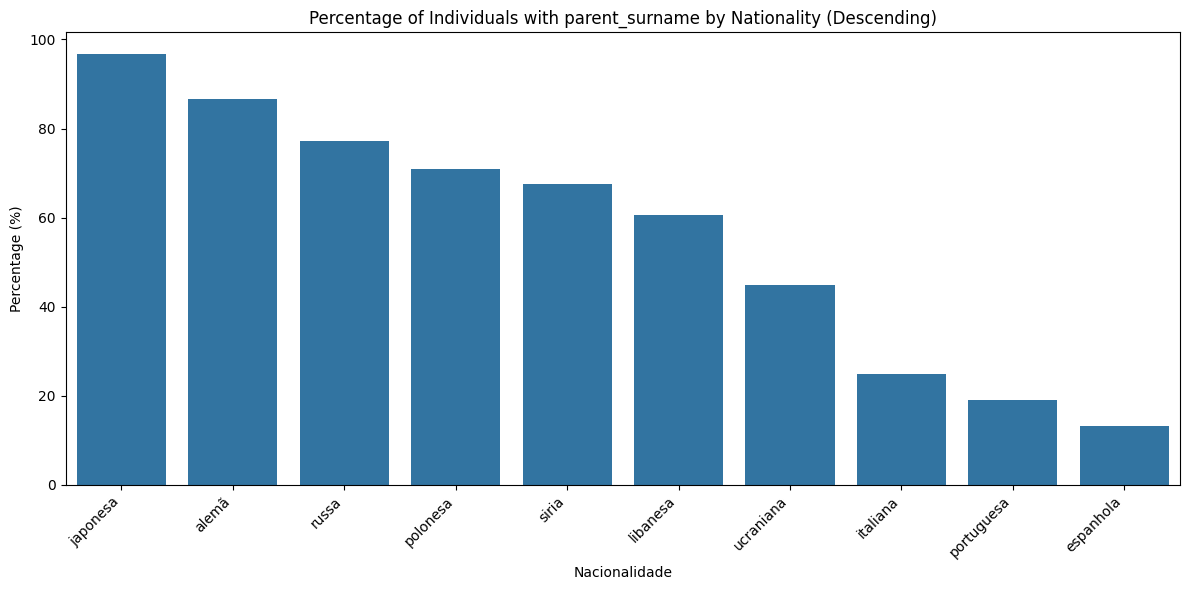

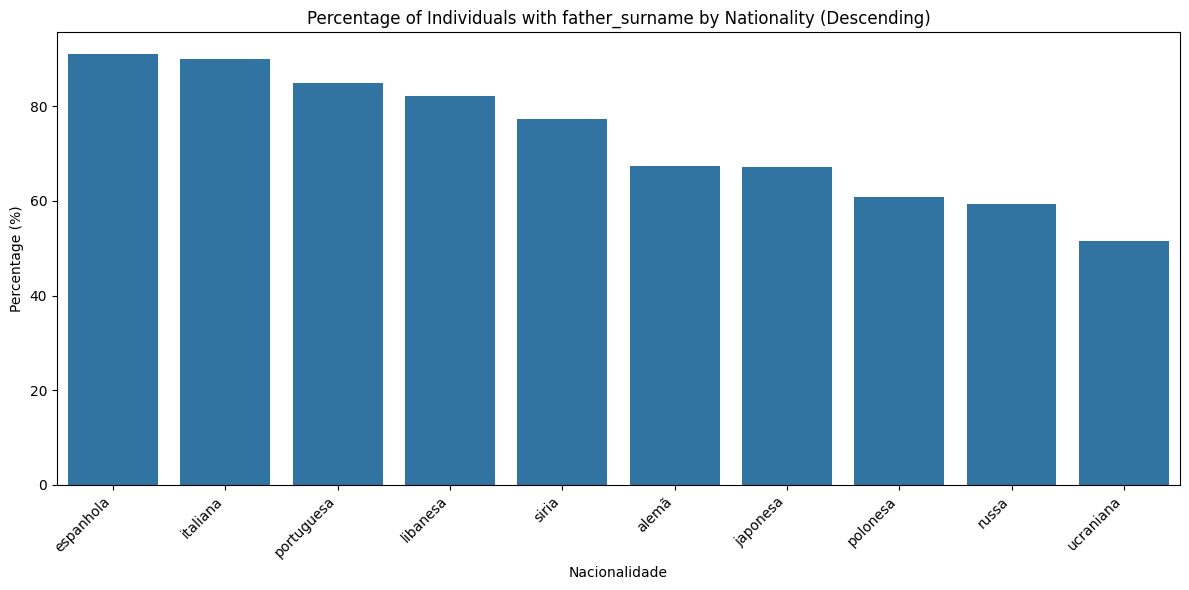

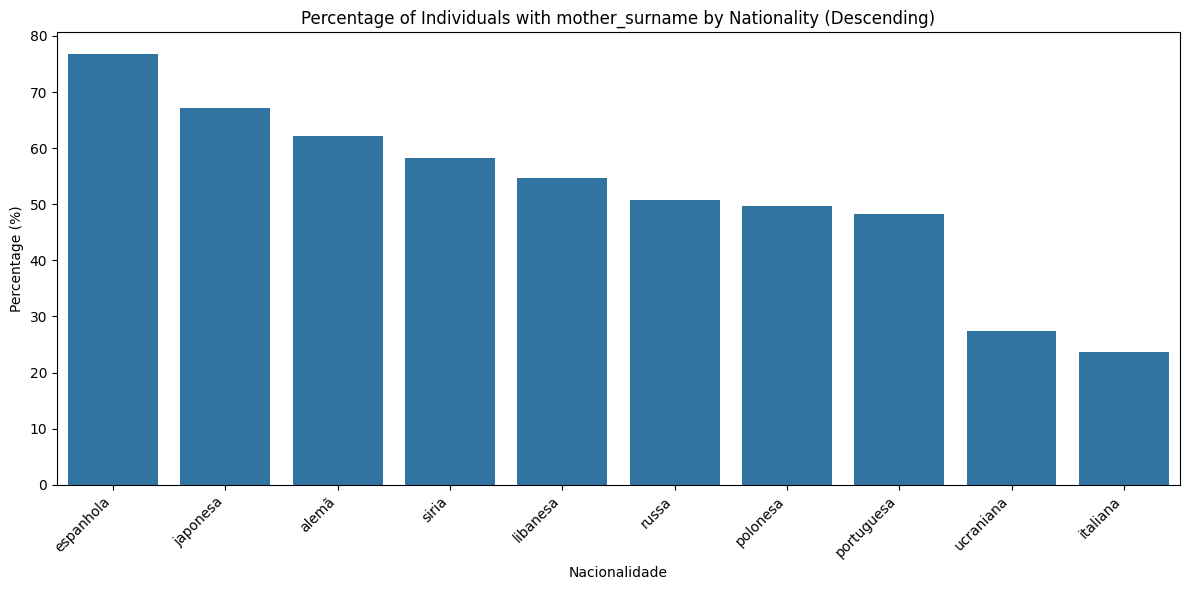

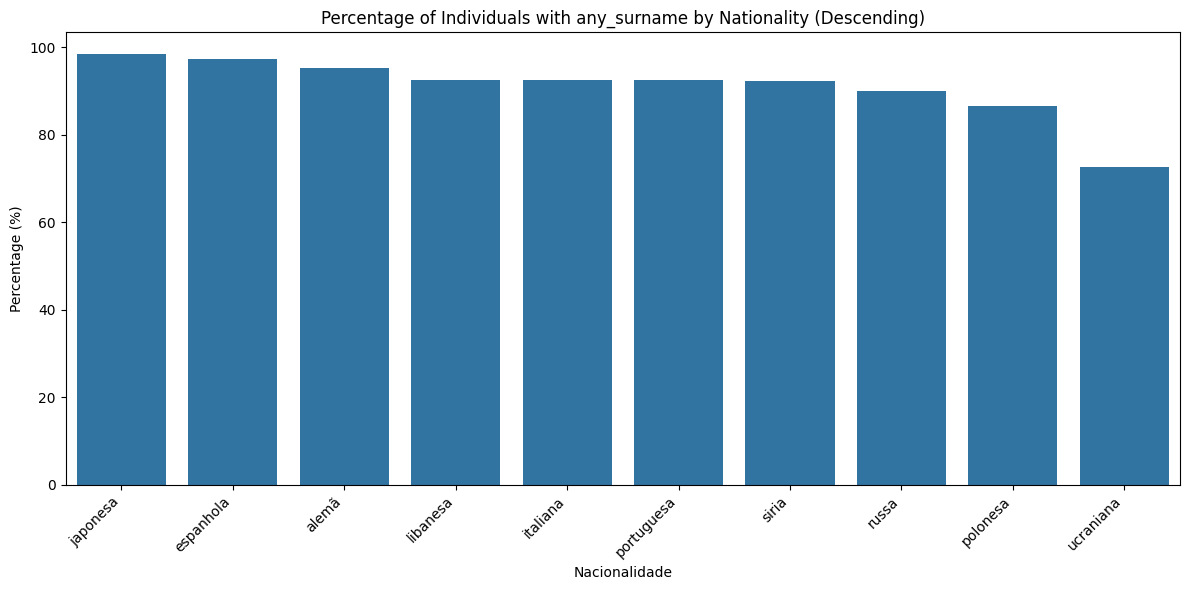

In [31]:
# Define the columns to plot
columns_to_plot = [
    "parent_surname_pct",
    "father_surname_pct",
    "mother_surname_pct",
    "any_surname_pct",
]

# Iterate through each column and create a bar plot
for col in columns_to_plot:
    plt.figure(figsize=(12, 6))

    # Sort the DataFrame by the current column in descending order
    sorted_surname_percentages = surname_percentages.sort_values(
        by=col, ascending=False
    )

    sns.barplot(x=sorted_surname_percentages.index, y=sorted_surname_percentages[col])
    plt.title(
        f"Percentage of Individuals with {col.replace('_pct', '')} by Nationality (Descending)"
    )
    plt.xlabel("Nacionalidade")
    plt.ylabel("Percentage (%)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [32]:
# prompt: display the percentage of rows in rne_post that contain at least one non null value among parent_surname, father_surname and mother_surname

# Calculate the number of rows with at least one non-null value in the specified columns
rows_with_non_null = rne_post[
    rne_post["parent_surname"].notna()
    | rne_post["father_surname"].notna()
    | rne_post["mother_surname"].notna()
].shape[0]

# Calculate the total number of rows
total_rows = rne_post.shape[0]

# Calculate the percentage
percentage = (rows_with_non_null / total_rows) * 100

# Print the result
print(
    f"{percentage:.2f}% of rows in 'rne_post' contain at least one non-null value among 'parent_surname', 'father_surname', and 'mother_surname'."
)

94.40% of rows in 'rne_post' contain at least one non-null value among 'parent_surname', 'father_surname', and 'mother_surname'.


label
iberica      344703
italiana     158321
japonesa     141150
germanica     42690
arabe         25126
leste         14134
Name: count, dtype: int64

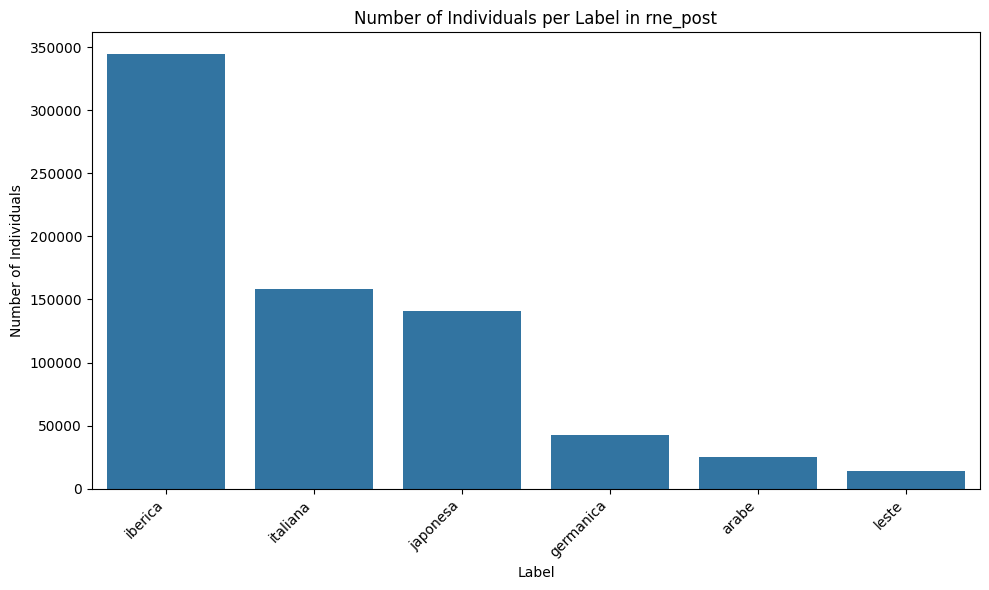

In [33]:
# prompt: plot the number of individuals per label as a bar graph in rne_post

display(rne_post["label"].value_counts())

label_counts_post = rne_post["label"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts_post.index, y=label_counts_post.values)
plt.title("Number of Individuals per Label in rne_post")
plt.xlabel("Label")
plt.ylabel("Number of Individuals")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [35]:
rne_post.to_csv(
    os.path.join(data_root, "intermediate", "rne_posprocessado.csv"), index=False
)

## Processando os sobrenomes únicos extraídos de cada nacionalidade

In [36]:
rne_post = pd.read_csv(os.path.join(data_root, "intermediate", "rne_posprocessado.csv"))

In [37]:
rne_test = rne_post.copy()

# Mantendo apenas linhas que tiveram algum sobrenome extraído
rne_test.dropna(
    subset=["parent_surname", "father_surname", "mother_surname"],
    how="all",
    inplace=True,
)

# Extraindo todos os sobrenomes únicos daquela linha, usando conjuntos
rne_test["unique_surnames"] = rne_test.apply(
    lambda row: list(
        set([row["parent_surname"], row["father_surname"], row["mother_surname"]])
        - {np.nan}
    ),
    axis=1,
)

# Calculando número de sobrenomes únicos daquela linha
rne_test["nunique_surnames"] = rne_test["unique_surnames"].apply(len)

# Eliminando as colunas "dedicadas" de sobrenomes
rne_test.drop(
    columns=["parent_surname", "father_surname", "mother_surname"], inplace=True
)

rne_test.reset_index(drop=True, inplace=True)

# generate a unique identifier for each row
rne_test["id"] = rne_test.index

rne_test

,nome_completo,estado_civil,nome_pai,nome_mae,ano_entrada,nacionalidade,pagina,label,unique_surnames,nunique_surnames,id
0,joachim wlademar hubertus ernst johannes arthu...,S,ernst joachim johannes arthur richard oldwig a...,annemarie hedwig klara freifrau von ledebur,1962.0,alemã,3969,germanica,"[von, ledebur]",2,0
1,joachim waldemar hubertus ernst johannes arthu...,C,ernst joachim johannes arthur richard oldwig a...,annemarie hedwig klara freiherr von ledebur,1968.0,alemã,3967,germanica,[ledebur],1,1
2,joachim waldemar hubertus ernst johannes arthu...,C,ernst joachim johannes arthur richard oldwig a...,annemarie hedwig klara freifrau von ledebur,1974.0,alemã,3968,germanica,[ledebur],1,2
3,dirk torsten kruger,C,friedrich hermann august wilhelm alfred ernst ...,edith marie luise kruger,1984.0,alemã,1161,germanica,[kruger],1,3
4,victor johann jakob franck,C,viktor nikolaus aurelius maria joseph aurelius...,maria elisabeth franck,1974.0,alemã,6705,germanica,[franck],1,4
...,...,...,...,...,...,...,...,...,...,...,...
685440,aurora nogueira,V,n n ',maria joaquina nogueira,1954.0,portuguesa,6281,iberica,[nogueira],1,685440
685441,leopold piechota,S,jan p,antonia p,1948.0,polonesa,726,leste,[piechota],1,685441
685442,luis bermudez ruiz,C,x x,isabel bermudez ruiz,1972.0,espanhola,9973,iberica,[ruiz],1,685442
685443,albina goncalves rebelo,C,n n,teresa goncalves,1975.0,portuguesa,1356,iberica,[goncalves],1,685443


In [38]:
rne_test.value_counts("label")

label
iberica      323833
italiana     146526
japonesa     138984
germanica     40641
arabe         23239
leste         12222
Name: count, dtype: int64

In [39]:
rne_test.value_counts("nunique_surnames")

nunique_surnames
1    550686
2    132758
3      2001
Name: count, dtype: int64

## Extração somente dos sobrenomes únicos por indivíduo e breve exploração por nacionalidade
* Número total de sobrenomes únicos (total, por label e nacionalidade)
* Número médio de pessoas por sobrenome para uma nacionalidade (medida da diversidade de sobrenomes para uma dada origem)
* Sobrenomes mais comuns por nacionalidade

In [40]:
rne_file = rne_test.copy()

rne_file = rne_file[
    [
        "id",
        "nome_completo",
        "nome_pai",
        "nome_mae",
        "unique_surnames",
        "nacionalidade",
        "label",
    ]
].copy()

rne_file = rne_file.explode("unique_surnames")

rne_file.rename(columns={"unique_surnames": "surname"}, inplace=True)

rne_file.dropna(inplace=True)

rne_file = rne_file.reset_index(drop=True)

# rne_file.to_csv(os.path.join(data_root, 'test/rne_test_file.csv'), index=False)

rne_file

,id,nome_completo,nome_pai,nome_mae,surname,nacionalidade,label
0,0,joachim wlademar hubertus ernst johannes arthu...,ernst joachim johannes arthur richard oldwig a...,annemarie hedwig klara freifrau von ledebur,von,alemã,germanica
1,0,joachim wlademar hubertus ernst johannes arthu...,ernst joachim johannes arthur richard oldwig a...,annemarie hedwig klara freifrau von ledebur,ledebur,alemã,germanica
2,1,joachim waldemar hubertus ernst johannes arthu...,ernst joachim johannes arthur richard oldwig a...,annemarie hedwig klara freiherr von ledebur,ledebur,alemã,germanica
3,2,joachim waldemar hubertus ernst johannes arthu...,ernst joachim johannes arthur richard oldwig a...,annemarie hedwig klara freifrau von ledebur,ledebur,alemã,germanica
4,3,dirk torsten kruger,friedrich hermann august wilhelm alfred ernst ...,edith marie luise kruger,kruger,alemã,germanica
...,...,...,...,...,...,...,...
822200,685440,aurora nogueira,n n ',maria joaquina nogueira,nogueira,portuguesa,iberica
822201,685441,leopold piechota,jan p,antonia p,piechota,polonesa,leste
822202,685442,luis bermudez ruiz,x x,isabel bermudez ruiz,ruiz,espanhola,iberica
822203,685443,albina goncalves rebelo,n n,teresa goncalves,goncalves,portuguesa,iberica


In [41]:
rne_file["surname"].nunique()

95381

In [42]:
rne_file.groupby(["label"])["surname"].nunique().rename("unique_surnames").sort_values(
    ascending=False
)

label
italiana     35127
iberica      20842
germanica    16664
japonesa     13352
leste         7812
arabe         6091
Name: unique_surnames, dtype: int64

In [43]:
rne_file.groupby(["label", "nacionalidade"])["surname"].nunique().rename(
    "unique_surnames"
)

label      nacionalidade
arabe      libanesa          4022
           siria             2880
germanica  alemã            16664
iberica    espanhola        16034
           portuguesa        6412
italiana   italiana         35127
japonesa   japonesa         13352
leste      polonesa          5381
           russa             2208
           ucraniana          476
Name: unique_surnames, dtype: int64

In [44]:
rne_file.groupby(["label", "nacionalidade"])["id"].nunique().rename("individuals")

label      nacionalidade
arabe      libanesa          16509
           siria              6730
germanica  alemã             40641
iberica    espanhola        107826
           portuguesa       216007
italiana   italiana         146526
japonesa   japonesa         138984
leste      polonesa           8739
           russa              2821
           ucraniana           662
Name: individuals, dtype: int64

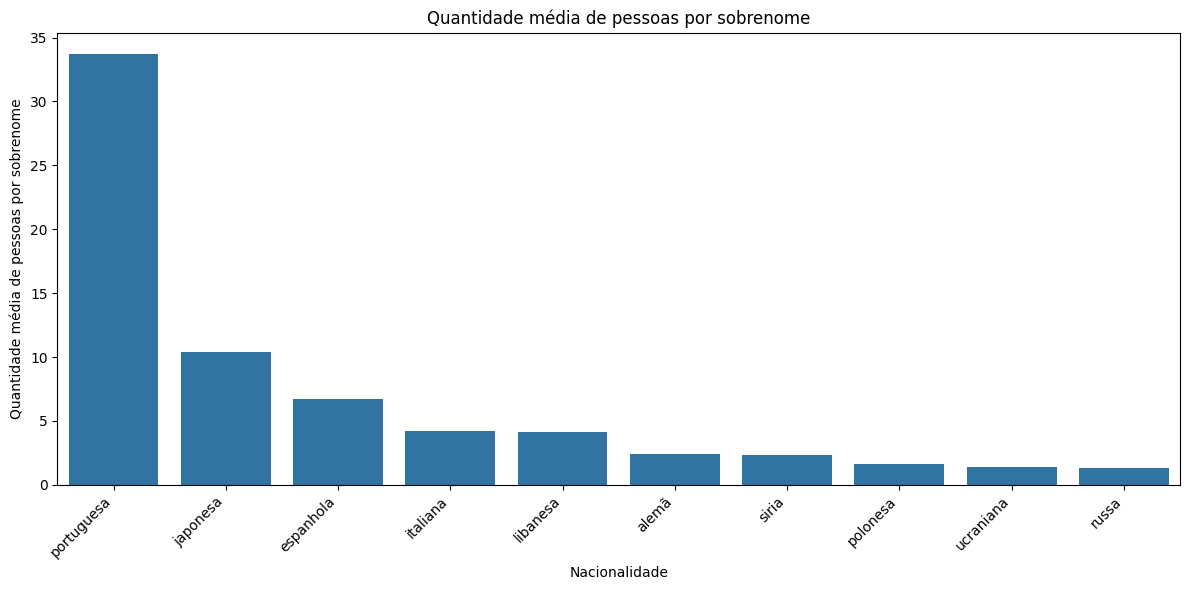

In [45]:
# prompt: plot the number of average people per surname per nationality and label as a bar graph

import pandas as pd
import matplotlib.pyplot as plt

# Calculate the number of unique individuals per nationality
individuals_per_nationality = (
    rne_file.groupby("nacionalidade")["id"].nunique().rename("individuals")
)

# Calculate the number of unique surnames per nationality
unique_surnames_per_nationality = (
    rne_file.groupby("nacionalidade")["surname"].nunique().rename("unique_surnames")
)

# Combine the two series into a single DataFrame
surname_diversity = pd.merge(
    individuals_per_nationality,
    unique_surnames_per_nationality,
    left_index=True,
    right_index=True,
)

# Calculate the average number of people per surname
surname_diversity["avg_people_per_surname"] = (
    surname_diversity["individuals"] / surname_diversity["unique_surnames"]
)

# Sort the values for better visualization
surname_diversity = surname_diversity.sort_values(
    "avg_people_per_surname", ascending=False
)

# Plot the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x=surname_diversity.index, y=surname_diversity["avg_people_per_surname"])
plt.title("Quantidade média de pessoas por sobrenome")
plt.xlabel("Nacionalidade")
plt.ylabel("Quantidade média de pessoas por sobrenome")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [46]:
top_surnames = rne_file.groupby(["label", "nacionalidade"], as_index=False)[
    "surname"
].value_counts()

for label, group in top_surnames.groupby("nacionalidade"):
    display(group.head(10))  # Display top 10 surnames for each nationality

,label,nacionalidade,surname,count
6902,germanica,alemã,muller,398
6903,germanica,alemã,schmidt,327
6904,germanica,alemã,meyer,210
6905,germanica,alemã,schneider,173
6906,germanica,alemã,weber,119
6907,germanica,alemã,fischer,118
6908,germanica,alemã,wagner,115
6909,germanica,alemã,hoffmann,106
6910,germanica,alemã,neumann,100
6911,germanica,alemã,schulz,93


,label,nacionalidade,surname,count
23566,iberica,espanhola,garcia,7644
23567,iberica,espanhola,perez,4161
23568,iberica,espanhola,fernandez,3985
23569,iberica,espanhola,rodriguez,3757
23570,iberica,espanhola,gonzalez,3668
23571,iberica,espanhola,martinez,3596
23572,iberica,espanhola,sanchez,2953
23573,iberica,espanhola,rodrigues,2361
23574,iberica,espanhola,lopez,2308
23575,iberica,espanhola,ruiz,1682


,label,nacionalidade,surname,count
46012,italiana,italiana,russo,594
46013,italiana,italiana,rossi,563
46014,italiana,italiana,romano,485
46015,italiana,italiana,ferrari,426
46016,italiana,italiana,bruno,332
46017,italiana,italiana,esposito,290
46018,italiana,italiana,lombardi,252
46019,italiana,italiana,bianco,245
46020,italiana,italiana,bianchi,241
46021,italiana,italiana,gallo,240


,label,nacionalidade,surname,count
81139,japonesa,japonesa,sato,1826
81140,japonesa,japonesa,watanabe,1395
81141,japonesa,japonesa,tanaka,1379
81142,japonesa,japonesa,nakamura,1302
81143,japonesa,japonesa,takahashi,1237
81144,japonesa,japonesa,suzuki,1145
81145,japonesa,japonesa,ito,1059
81146,japonesa,japonesa,saito,990
81147,japonesa,japonesa,yamamoto,936
81148,japonesa,japonesa,higa,799


,label,nacionalidade,surname,count
0,arabe,libanesa,khouri,279
1,arabe,libanesa,mourad,278
2,arabe,libanesa,haddad,258
3,arabe,libanesa,saleh,170
4,arabe,libanesa,fares,146
5,arabe,libanesa,kadri,129
6,arabe,libanesa,youssef,120
7,arabe,libanesa,orra,119
8,arabe,libanesa,khalil,106
9,arabe,libanesa,saad,105


,label,nacionalidade,surname,count
94491,leste,polonesa,goldberg,26
94492,leste,polonesa,szewczuk,21
94493,leste,polonesa,kac,20
94494,leste,polonesa,horowicz,18
94495,leste,polonesa,farber,15
94496,leste,polonesa,kowalczuk,15
94497,leste,polonesa,ostrowski,15
94498,leste,polonesa,rojtman,15
94499,leste,polonesa,nowak,14
94500,leste,polonesa,wojciechowski,14


,label,nacionalidade,surname,count
39600,iberica,portuguesa,silva,12200
39601,iberica,portuguesa,santos,10397
39602,iberica,portuguesa,pereira,8847
39603,iberica,portuguesa,rodrigues,8011
39604,iberica,portuguesa,ferreira,7937
39605,iberica,portuguesa,jesus,6620
39606,iberica,portuguesa,fernandes,6329
39607,iberica,portuguesa,gomes,5870
39608,iberica,portuguesa,goncalves,5446
39609,iberica,portuguesa,martins,4736


,label,nacionalidade,surname,count
99872,leste,russa,lerner,10
99873,leste,russa,ivanoff,7
99874,leste,russa,karlik,7
99875,leste,russa,kogan,7
99876,leste,russa,schmidt,7
99877,leste,russa,akerman,6
99878,leste,russa,andrushek,6
99879,leste,russa,derkatscheff,6
99880,leste,russa,kauffmann,6
99881,leste,russa,koifman,6


,label,nacionalidade,surname,count
4022,arabe,siria,haddad,113
4023,arabe,siria,elias,92
4024,arabe,siria,jorge,62
4025,arabe,siria,issa,61
4026,arabe,siria,cury,56
4027,arabe,siria,salomao,49
4028,arabe,siria,ibrahim,44
4029,arabe,siria,nahas,42
4030,arabe,siria,saad,39
4031,arabe,siria,simao,37


,label,nacionalidade,surname,count
102080,leste,ucraniana,petrenko,9
102081,leste,ucraniana,kolisnyk,5
102082,leste,ucraniana,petrow,5
102083,leste,ucraniana,sawka,5
102084,leste,ucraniana,fedorenko,4
102085,leste,ucraniana,jarowys,4
102086,leste,ucraniana,kosimenko,4
102087,leste,ucraniana,mielniczuk,4
102088,leste,ucraniana,poczekwa,4
102089,leste,ucraniana,poliszczuk,4


In [47]:
rne_ground_truth = rne_file.copy()

rne_ground_truth.drop(columns=["nome_completo", "nome_pai", "nome_mae"], inplace=True)

rne_ground_truth.to_csv(
    os.path.join(data_root, "intermediate", "rne_ground_truth.csv"), index=False
)

# Extraindo a determinação de frequência
* Para cada rótulo, extraímos um dataframe contendo todos os nomes únicos, a incidência (quantidade de vezes que aquele nome aparece para aquele rótulo), e a frequência (percentual do total de indivíduos que carrega aquele nome no grupo)

In [49]:
rne_ground_truth = pd.read_csv(
    os.path.join(data_root, "intermediate", "rne_ground_truth.csv")
)

In [50]:
rne_freqs = {}

for label, group in rne_ground_truth.groupby("label"):
    temp = group["surname"].value_counts()
    temp = temp.reset_index()
    temp["total"] = group["id"].nunique()
    temp["pct"] = (temp["count"] / temp["total"]) * 100

    temp.rename(columns={"count": "incid", "pct": "freq"}, inplace=True)
    # temp.drop(columns=['total'], inplace=True)
    # temp.columns = ['surname', 'incid', 'freq']
    rne_freqs[label] = temp

rne_freqs.keys()

dict_keys(['arabe', 'germanica', 'iberica', 'italiana', 'japonesa', 'leste'])

## Matriz de comparação de frequências

In [52]:
def preprocess_surname_table(name, surn_df, cutoff=None):
    res_df = surn_df.copy()

    if cutoff is not None:
        res_df = res_df[res_df["freq"] >= cutoff]

    res_df = res_df.rename(columns={"freq": f"freq_{name}"})
    if "incid" in res_df.columns:
        res_df = res_df.drop(columns=["incid"])
    if "total" in res_df.columns:
        res_df = res_df.drop(columns=["total"])

    return res_df


def create_surnames_total(surns, cutoff=None):
    surn_total = pd.DataFrame(columns=["surname"])
    for name, surn_df in surns.items():
        preprocessed_surn_df = preprocess_surname_table(name, surn_df, cutoff)
        # display(preprocessed_surn_df.head())
        surn_total = pd.merge(
            surn_total, preprocessed_surn_df, on="surname", how="outer"
        )
    surn_total = surn_total.fillna(0)
    return surn_total

In [53]:
rne_totals = create_surnames_total(rne_freqs, cutoff=None)

rne_totals

,surname,freq_arabe,freq_germanica,freq_iberica,freq_italiana,freq_japonesa,freq_leste
0,'oglio,0.000000,0.000000,0.000000,0.000682,0.0,0.000000
1,-tem,0.000000,0.000000,0.000309,0.000000,0.0,0.000000
2,a,0.000000,0.002461,0.000618,0.000682,0.0,0.000000
3,aab,0.000000,0.002461,0.000000,0.000000,0.0,0.000000
4,aafarani,0.008606,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
95376,zyskind,0.000000,0.000000,0.000000,0.000000,0.0,0.008182
95377,zysman,0.000000,0.000000,0.000000,0.000000,0.0,0.049092
95378,zytnik,0.000000,0.000000,0.000000,0.000000,0.0,0.008182
95379,zyturus,0.000000,0.014763,0.000000,0.000000,0.0,0.000000


In [55]:
ambiguous_names = rne_totals[(rne_totals.iloc[:, 1:] > 0).sum(axis=1) > 1]
ambiguous_names

,surname,freq_arabe,freq_germanica,freq_iberica,freq_italiana,freq_japonesa,freq_leste
2,a,0.000000,0.002461,0.000618,0.000682,0.0,0.000000
5,abad,0.025819,0.000000,0.027175,0.000000,0.0,0.000000
7,abade,0.000000,0.000000,0.003088,0.000682,0.0,0.000000
11,abadi,0.008606,0.000000,0.000000,0.001365,0.0,0.000000
12,abadia,0.000000,0.000000,0.000618,0.001365,0.0,0.000000
...,...,...,...,...,...,...,...
95159,zucchetti,0.000000,0.002461,0.000000,0.000682,0.0,0.000000
95161,zucchi,0.004303,0.000000,0.000000,0.014332,0.0,0.000000
95263,zuniga,0.000000,0.002461,0.005250,0.000000,0.0,0.000000
95272,zupnik,0.000000,0.002461,0.000000,0.000000,0.0,0.016364


In [56]:
def create_ground_truth(surn_freq_matrix, decision_ratio=2):
    # todo: create ambiguous category threshold

    gt_df = pd.DataFrame(columns=["surname", "origin"])

    freq_cols = [col for col in surn_freq_matrix.columns if "freq" in col]

    for col_a in freq_cols:
        origin = col_a.split("_")[1]
        temp = surn_freq_matrix[surn_freq_matrix[col_a] > 0].copy()
        for col_b in freq_cols:
            if col_b != col_a:
                ratio_name = f"ratio_{origin}_{col_b.split('_')[1]}"
                temp[ratio_name] = temp[col_a] / temp[col_b]

        ratio_cols = [col for col in temp.columns if "ratio_" in col]

        filtered_temp = temp[(temp[ratio_cols] > decision_ratio).all(axis=1)].copy()

        filtered_temp["origin"] = origin
        filtered_temp = filtered_temp[["surname", "origin"]]
        gt_df = pd.concat([gt_df, filtered_temp], ignore_index=True)

    return gt_df

In [57]:
names_origins_gt = create_ground_truth(rne_totals)

In [58]:
print(names_origins_gt.shape)

names_origins_gt.value_counts("origin")

(94458, 2)


origin
italiana     33431
iberica      18990
germanica    15639
japonesa     13172
leste         7354
arabe         5872
Name: count, dtype: int64

In [59]:
# prompt: calculate the intersection of ambiguous names ['surname'] and names_origins_gt ['surname'] in number of unique elements

num_ambiguous_surnames = len(ambiguous_names["surname"].unique())
num_gt_surnames = len(names_origins_gt["surname"].unique())

# Calculate the number of unique surnames in the intersection
intersection_count = len(
    set(ambiguous_names["surname"]).intersection(set(names_origins_gt["surname"]))
)

print(f"Number of unique surnames in the intersection: {intersection_count}")

Number of unique surnames in the intersection: 3112


In [63]:
names_origins_gt.to_csv(
    os.path.join(data_root, "outputs", "final_rne_ground_truth.csv"), index=False
)